In [1]:
import matplotlib.pyplot as plt
from data_preparation.basics import *
from data_exploration import *

from rdkit import Chem

import pandas as pd
pd.set_option('display.max_rows', 20)

In [2]:
task = 'CYP2C9'
data = load_tdc_dataset_split(task)

Found local copy...
Loading...
Done!


# Data Exploration

In [3]:
data['train']

,Drug_ID,Drug,Y
0,1960010.0,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1
1,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1
2,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1
3,644968.0,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1
4,6602688.0,Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c...,1
...,...,...,...
8460,16758810.0,C[C@@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]...,0
8461,16758813.0,O=C1C=C[C@@H](O)[C@@H]2[C@@H]1CC[C@H]1C(=O)N(C...,0
8462,16758816.0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,0
8463,16758818.0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,0


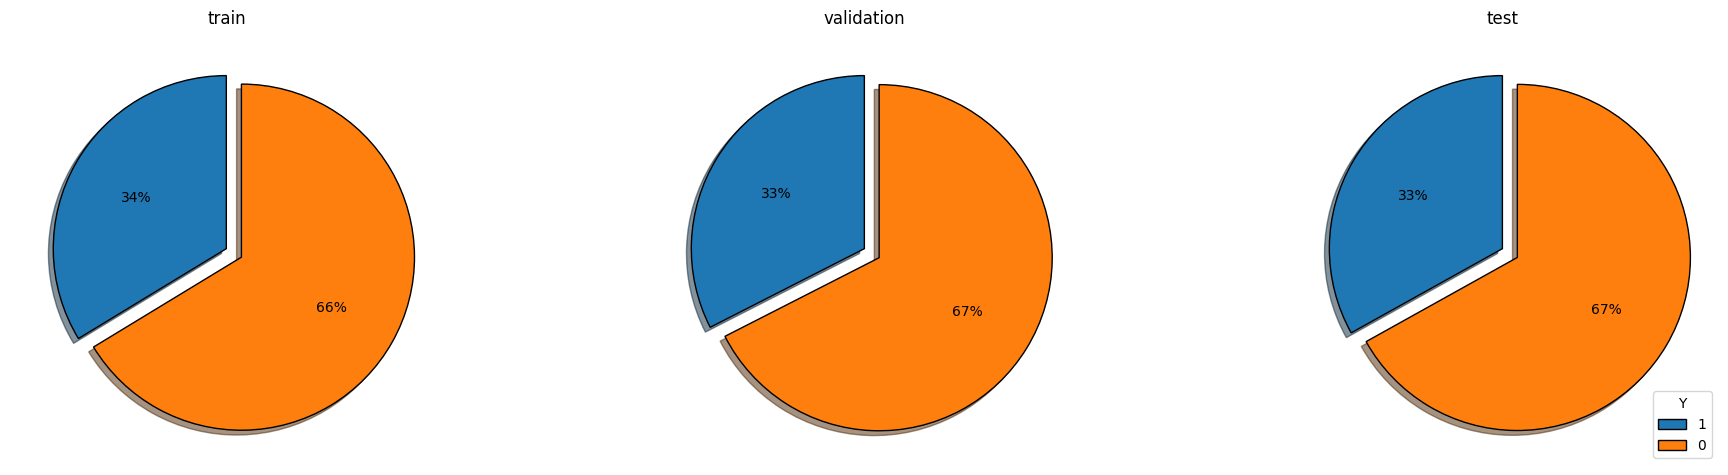

In [4]:
plot_counts([data['train']["Y"], data['valid']["Y"], data['test']["Y"]], ['train', 'validation', 'test'], kind="pie")